In [1]:
import torch
import numpy as np

from typing import Union
from torchvision import transforms
from PIL import Image
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.schedulers import DDPMScheduler

In [2]:
image = Image.open("../1_media/input_images/cat.jpg").convert("RGB")

prompt = "a beautiful cat with a human face"
negative_prompt = None
seed = -1
guidance_scale = 5
num_inference_steps = 4
strength = 0.6
num_images_per_prompt = 1
batch_size = 1
device = "cuda"
dtype = torch.float16

In [3]:
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae").to(device=device, dtype=dtype)
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet").to(device=device, dtype=dtype)
scheduler = DDPMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")

* padding :

    * "max_length" : Belirtilen maksimum uzunluğa veya model için kabul edilebilir maksimum giriş uzunluğuna kadar padding yapılır.
    * "longest" veya True : Prompt batch halinde verildiyse, batch içindeki promptlardan en uzun olanına göre padding yapılır. Eğer bir prompt varsa padding yapılmaz.
    * "do_not_pad" veya False : Padding yapılmaz.


* max_length : Padding veya truncation için maksimum uzunluk. Eğer padding veya truncation yapılacaksa bu değer kullanılır. Ayarlanmadan bırakılırsa veya None olarak ayarlanırsa, model için kabul edilebilir maksimum giriş uzunluğu kullanılır.

* truncation :

    * True veya "longest_first" : max_length değişkeniyle verilen maksimum uzunluğa veya bu değişken sağlanmamışsa model için kabul edilebilir maksimum uzunluğa kadar kesme yapılır. 

In [6]:
def encode_prompt(tokenizer : CLIPTokenizer, 
              text_encoder : CLIPTextModel, 
              prompt : Union[str,list], 
              negative_prompt : Union[str,list], 
              num_images_per_prompt : int, 
              cfg: bool):

    if prompt is not None and isinstance(prompt, str):
        batch_size = 1
    elif prompt is not None and isinstance(prompt, list):
        batch_size = len(prompt)
    else:
        batch_size = prompt_embeds.shape[0]
   
    # Prompt tokenize
    tokens = tokenizer(prompt,
                       padding="max_length",
                       max_length=tokenizer.model_max_length,
                       truncation=True,
                       return_tensors="pt")
    
    #print("Tokens:", tokens, "attention_mask hakkinda daha fazla bilgi icin: https://huggingface.co/transformers/glossary.html#attention-mask")
        
    tokens_ids = tokens.input_ids
    print("Tokens IDs:", tokens_ids)


    # Untrancated hesabı, gerek yok, diffusers kesilen prompt parçasını warning basmak için hesaplıyor.
    """ untruncated_ids = tokenizer(prompt, padding="do_not_pad", return_tensors="pt").input_ids
    print("Untrancated IDs:", untruncated_ids)

    if untruncated_ids.shape[-1] >= tokens_ids.shape[-1] and not torch.equal(tokens_ids, untruncated_ids):
        removed_text = tokenizer.batch_decode(untruncated_ids[:, tokenizer.model_max_length - 1 : -1])
        print("Removed Text:", removed_text) """

    # Model text encoder config dosyasında use_attention_mask varsa ve True ise attention maskı kullan.
    if hasattr(text_encoder.config, "use_attention_mask") and text_encoder.config.use_attention_mask:
        attention_mask = tokens.attention_mask
        
    else:
        attention_mask = None
    print("Attention Mask:", attention_mask)


    # Prompt embeds
    prompt_embeds = text_encoder(tokens_ids, attention_mask=attention_mask) # text encoder encode edilmiş promptu döner
    prompt_embeds = prompt_embeds[0]
   
    print("Prompt Embeds:", prompt_embeds.shape)

    # duplicate prompt embeds for each image
    bs_embed, seq_len, _ = prompt_embeds.shape
    prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
    print("Prompt Embeds Repeated Shape:", prompt_embeds.shape)

    prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)
    print("Prompt Embeds View Shape:", prompt_embeds.shape)

    # negative prompt
    if negative_prompt is None:
        uncond_tokens = [""] * batch_size

    elif isinstance(negative_prompt, str):
        uncond_tokens = [negative_prompt]
    else:
        uncond_tokens = negative_prompt
    
    # negative prompt tokenize
    max_length = prompt_embeds.shape[1]
    uncond_tokens = tokenizer(uncond_tokens,
                             padding="max_length",
                             max_length=max_length,
                             truncation=True,
                             return_tensors="pt")

    if hasattr(text_encoder.config, "use_attention_mask") and text_encoder.config.use_attention_mask:
        attention_mask = uncond_tokens.attention_mask
    else:
        attention_mask = None

    uncond_tokens_ids = uncond_tokens.input_ids
    negative_prompt_embeds = text_encoder(uncond_tokens_ids, attention_mask=attention_mask)
    negative_prompt_embeds = negative_prompt_embeds[0]

    if cfg:
        seq_len = negative_prompt_embeds.shape[1]

        negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
        negative_prompt_embeds = negative_prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)
            
        prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

    return prompt_embeds

In [7]:
prompt_embeds = encode_prompt(tokenizer, text_encoder, prompt, negative_prompt, num_images_per_prompt = 1, cfg = False)

Tokens IDs: tensor([[49406,   320,  1215,  2368,   593,   320,  2751,  1710, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])
Attention Mask: None
Prompt Embeds: torch.Size([1, 77, 768])
Prompt Embeds Repeated Shape: torch.Size([1, 77, 768])
Prompt Embeds View Shape: torch.Size([1, 77, 768])


In [9]:
def image_preprocess(image: Image, height: int, width: int, device: torch.device, dtype: torch.dtype):
    
    image = image.resize((width, height), Image.LANCZOS)

    # pil to np
    image = np.array(image).astype(np.float32) / 255.0

    # np to torch pt
    if image.ndim == 3:
        image = image[..., None]

    image = torch.from_numpy(image.transpose(3,2,0,1))
    
    # expected range [0,1], normalize to [-1,1]
    if image.min() < 0:
        print(
            "Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] "
            f"when passing as pytorch tensor or numpy Array. You passed `image` with value range [{image.min()},{image.max()}]",
            FutureWarning,
        )

    image = 2.0 * image - 1.0
    image = image.to(device=device, dtype=dtype)

    return image

In [10]:
def image_postprocess(image: torch.FloatTensor):
        
        image = (image / 2 + 0.5).clamp(0, 1)
        
        # torch pt to np
        image = image.cpu().permute(0, 2, 3, 1).float().detach().numpy()

        if image.ndim == 3:
            image = image[..., None]

        image = torch.from_numpy(image.transpose(0, 3, 1, 2))
        image = image.squeeze(0)
        pil_image = transforms.ToPILImage()(image)  

        return pil_image

In [11]:
def get_timesteps(scheduler, num_inference_steps, strength):
        
        init_timestep = min(int(num_inference_steps * strength), num_inference_steps)
        t_start = max(num_inference_steps - init_timestep, 0)
        timesteps = scheduler.timesteps[int(t_start) * scheduler.order : ]
        
        return timesteps, num_inference_steps - t_start

In [12]:
def prepare_latents(image, timestep, batch_size, num_images_per_prompt, dtype, device, vae, scheduler, generator=None):
        print("Prepare Latents")
        batch_size = batch_size * num_images_per_prompt

        if image.shape[1] == 4:
            init_latents = image

        else:
            init_latents = vae.encode(image).latent_dist.sample(generator)
            init_latents = vae.config.scaling_factor * init_latents
            init_latents = torch.cat([init_latents], dim=0)

        shape = init_latents.shape
        noise = torch.randn(shape, generator=generator, device=device, dtype=dtype, layout=torch.strided)
        # get latents
        init_latents = scheduler.add_noise(init_latents, noise, timestep)
        latents = init_latents

        return latents

In [13]:
def custom_pipeline(vae,
                 unet,
                 scheduler,
                 tokenizer,
                 text_encoder,
                 image, 
                 prompt,
                 negative_prompt, 
                 seed, 
                 guidance_scale: float = 7.5,
                 num_inference_steps: int = 25, 
                 strength: float = 0.5, 
                 num_images_per_prompt: int = 1, 
                 batch_size: int = 1, 
                 device: str = "cuda",
                 dtype: torch.dtype = torch.float16):

    # seedi ayarla
    if seed == -1:
        seed = np.random.randint(0, 1000000)
    generator = torch.Generator(device=device).manual_seed(seed)

    # guidance scale ayarla
    cfg = guidance_scale > 1

    # encode prompt
    prompt_embeds = encode_prompt(tokenizer, text_encoder, prompt, negative_prompt, num_images_per_prompt, cfg)
    prompt_embeds = prompt_embeds.to(device=device, dtype=dtype)
    height = image.size[1]
    width = image.size[0]
    print("Image Size:", height, width)
    # image preprocess
    image = image_preprocess(image, height=height, width=width, device=device, dtype=dtype)

    # create scheduler timesteps
    scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps, num_inference_steps = get_timesteps(scheduler,num_inference_steps, strength)
    latent_timestep = timesteps[:1].repeat(batch_size * num_images_per_prompt)

    # latents kısmı
    latents = prepare_latents(image=image,
                              timestep=latent_timestep,
                              batch_size=batch_size,
                              num_images_per_prompt=num_images_per_prompt,
                              dtype=prompt_embeds.dtype,
                              device=device,
                              vae=vae,
                              scheduler=scheduler,
                              generator=generator)
    
    print("Latents Shape:", latents.shape)

    # unet loop kısmı
    for i, t in enumerate(timesteps):
       
        latent_model_input = torch.cat([latents] * 2) if cfg else latents
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
       
        # unet forward
        noise_pred = unet(
            latent_model_input,
            t,
            encoder_hidden_states=prompt_embeds,
            return_dict=False
        )[0]

        # perform guidance
        if cfg:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents, return_dict=False)[0]

        print(f"{i}/{num_inference_steps} latents: {latents.shape}")

    image = vae.decode(latents / vae.config.scaling_factor, return_dict=False)[0]
    image = image_postprocess(image)
    
    return image


Tokens IDs: tensor([[49406,   320,  1215,  2368,   593,   320,  2751,  1710, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])
Attention Mask: None
Prompt Embeds: torch.Size([1, 77, 768])
Prompt Embeds Repeated Shape: torch.Size([1, 77, 768])
Prompt Embeds View Shape: torch.Size([1, 77, 768])
Image Size: 463 703
Prepare Latents


/home/server/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Latents Shape: torch.Size([1, 4, 57, 87])


/home/server/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


0/2 latents: torch.Size([1, 4, 57, 87])
1/2 latents: torch.Size([1, 4, 57, 87])


Text(0.5, 1.0, 'Generated')

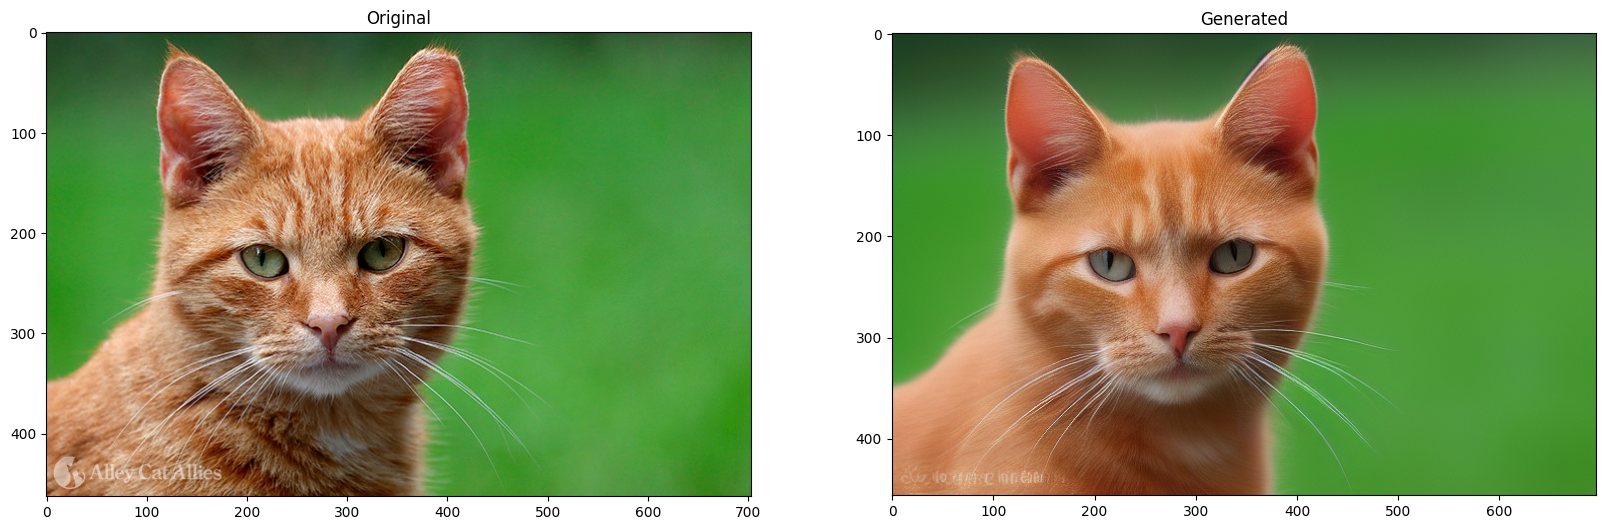

In [14]:
generated_image = custom_pipeline(vae=vae,
                               unet=unet,
                               scheduler=scheduler,
                               tokenizer=tokenizer,
                               text_encoder=text_encoder,
                               image=image,
                               prompt=prompt,
                               negative_prompt=negative_prompt,
                               seed=seed,
                               guidance_scale=guidance_scale,
                               num_inference_steps=num_inference_steps,
                               strength=strength,
                               num_images_per_prompt=num_images_per_prompt,
                               batch_size=batch_size,
                               device=device,
                               dtype=dtype)

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
fig = plt.figure(figsize = (20, 20), facecolor = 'white')
fig.add_subplot(1, 2, 1)
  
# showing image
plt.imshow(image)
plt.axis('on')
plt.title("Original")
  
# Adds a subplot at the 2nd position
fig.add_subplot(1, 2, 2)
  
# showing image
plt.imshow(generated_image)
plt.axis('on')
plt.title("Generated")
